In [3]:
import os
import math
import datetime
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve

## General functions

In [4]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

def rounddown(x):
    return math.floor(x/10) * 10

def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

In [5]:
# curve data
os.chdir('INSERT_DATA_PATH_HERE')
EUSA = pd.read_excel('EUSA_data.xlsx')

tau_floating_leg = 0.5

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M','1Y', '2Y', '3Y','4Y','5Y', '6Y','7Y','8Y','9Y', '10Y', '12Y', '15Y', '20Y', '25Y','30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

def disc_factor(date, T, df_curve = EUSA):
    return ((1 + cubspline_curve(date, T, df_curve)) ** (-T))

def payment_schedule(date, expiry, tenor, delta=tau_floating_leg):
    unadj_dates = []
    adj_dates = []

    t_0 = pd.Timestamp(date).date()
    t_m = (t_0 + DateOffset(months=(expiry * 12)) + pd.tseries.offsets.BusinessDay(0)).date()
    t_n = (t_m + DateOffset(months=(tenor * 12))).date()
    t_m_copy = t_m

    delta_months = relativedelta(months=+(delta * 12))

    while t_m_copy < t_n:
        unadj_dates.append(t_m_copy)
        t_m_copy = t_m_copy + delta_months

    unadj_dates.append(t_m_copy)

    for date in unadj_dates:
        adj_dates.append((date + pd.tseries.offsets.BusinessDay(0)).date())
    
    return adj_dates

def coverage(date, expiry, tenor, delta=tau_floating_leg):
    coverage = []
    dates = []

    adj_dates = payment_schedule(date, expiry, tenor, delta)
    t_0 = pd.Timestamp(date).date()
    dates_roll = expiry + delta

    for i in range(1, len(adj_dates)):
        coverage.append(1 / 360 * (
            360 * (adj_dates[i].year - adj_dates[i - 1].year)
            + 30 * (adj_dates[i].month - adj_dates[i - 1].month)
            + min(30, adj_dates[i].day) 
            - min(30, adj_dates[i - 1].day)
            )
        )
        dates.append(dates_roll)
        dates_roll = dates_roll + coverage[i - 1]

    return coverage, dates

def annuity_func(date, expiry, tenor, delta=tau_floating_leg, df_curve=EUSA):
    ann = 0
    cov, dates = coverage(date, expiry, tenor, delta)
    for i in range(len(dates)):
        ann = ann + disc_factor(date, dates[i], df_curve) * cov[i]
    return ann

def bachelier(F, K, sigma_normal, date, expiry, tenor, delta = tau_floating_leg, t = 0):
    d = (F - K) / (sigma_normal * np.sqrt(expiry - t))
    return annuity_func(date, expiry, tenor, delta) * sigma_normal * np.sqrt(expiry - t) * (d * norm.cdf(d) + norm.pdf(d))

## Payer function

In [7]:
def char_func(u, T, theta, eta, z_0, lambd, b):
    v = 1/2 * (lambd * b)**2 * u * (u - 1)

    gamma = np.sqrt(theta**2 - 2 * eta**2 * v)
    A = 1 / eta**2 * theta * z_0 * (2 * np.log(2 * gamma / (theta + gamma - np.exp(-gamma * T)*(theta - gamma))) + (theta - gamma) * T)
    B = 2 * v * (1 - np.exp(-gamma * T)) / ((theta + gamma) * (1 - np.exp(-gamma * T)) + 2 * gamma * np.exp(-gamma * T))
    return np.exp(A + B * z_0)

def payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor):
    xmin = 0
    xmax = 2000
    int_points = 10000
    [u, wgt] = trap_integration(xmin, xmax, int_points)
    
    S_prime = b * S + (1 - b) * L
    K_prime = b * K + (1 - b) * L

    integrand = np.real((np.exp(-(1/2 + 1j * u) * np.log(K_prime / S_prime)) * char_func(1/2 + 1j * u, expiry, theta, eta, z_0, lambd, b)) / (u**2 + 1/4))
    integral = sum(wgt * integrand)

    annuity = annuity_func(date, expiry, tenor, delta=tau_floating_leg, df_curve=EUSA)

    return annuity / b * (S_prime - K_prime / np.pi * integral)

date = datetime.date(2023, 9, 18)
expiry = 5
tenor = 10
tau_floating_leg = 0.5
z_0 = 1

S = 0.032
L = S

### $\lambda$

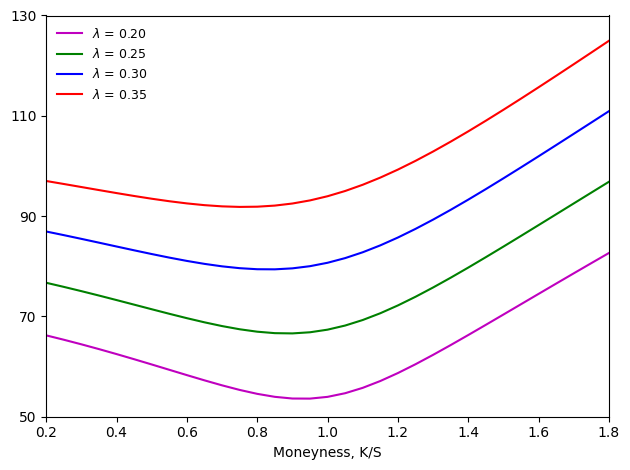

In [8]:
b = 0.4
eta = 1.5
theta = 0.2

mness = np.arange(0.2, 1.85, 0.05)
strikes = mness * S
lambds = np.array([0.2, 0.25, 0.3, 0.35])

prices = np.empty((len(lambds), len(strikes)))
IV = np.empty((len(lambds), len(strikes)))

for n in range(len(lambds)):
    lambd = lambds[n]

    for i in range(len(strikes)):
        K = strikes[i]
        prices[n,i] = payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor)
        
        def bachelier_iv(x):
            return bachelier(S, K, x, date, expiry, tenor, delta = tau_floating_leg, t = 0) - prices[n,i]
        res = fsolve(bachelier_iv, 0.01)
        IV[n,i] = res * 10000   # convert to bp

fig, ax = plt.subplots()

ax.set_yticks(np.arange(rounddown(min(IV[0,:]))-20, roundup(max(IV[3,:]))+20, 20))
ax.set_ylim(rounddown(min(IV[0,:])), roundup(max(IV[3,:])))
ax.set_xlim(min(mness), max(mness))
ax.set_xlabel('Moneyness, K/S')
plt.plot(mness, IV[0,:], color = 'm', label = '$\\lambda$ = 0.20')
plt.plot(mness, IV[1,:], color = 'g', label = '$\\lambda$ = 0.25')
plt.plot(mness, IV[2,:], color = 'b', label = '$\\lambda$ = 0.30')
plt.plot(mness, IV[3,:], color = 'r', label = '$\\lambda$ = 0.35')
plt.legend(frameon=False, loc = 'upper left', fontsize=9)
fig.tight_layout()

### b

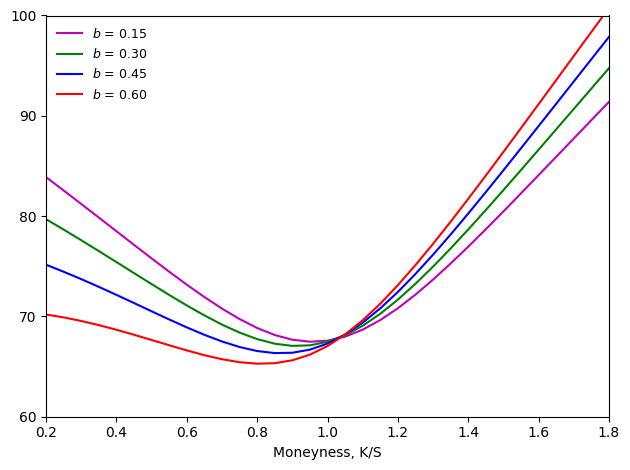

In [9]:
lambd = 0.25
eta = 1.5
theta = 0.2

mness = np.arange(0.2, 1.85, 0.05)
strikes = mness * S
bs = np.array([0.15, 0.3, 0.45, 0.6])

prices = np.empty((len(bs), len(strikes)))
IV = np.empty((len(bs), len(strikes)))

for n in range(len(bs)):
    b = bs[n]

    for i in range(len(strikes)):
        K = strikes[i]
        prices[n,i] = payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor)
        
        def bachelier_iv(x):
            return bachelier(S, K, x, date, expiry, tenor, delta = tau_floating_leg, t = 0) - prices[n,i]
        res = fsolve(bachelier_iv, 0.01)
        IV[n,i] = res * 10000   # convert to bp

fig, ax = plt.subplots()

ax.set_yticks(np.arange(rounddown(min(IV[0,:])), roundup(max(IV[3,:])), 10))
ax.set_ylim(rounddown(min(IV[0,:])), roundup(max(IV[3,:]))-10)
ax.set_xlim(min(mness), max(mness))
ax.set_xlabel('Moneyness, K/S')
plt.plot(mness, IV[0,:], color = 'm', label = '$b$ = 0.15')
plt.plot(mness, IV[1,:], color = 'g', label = '$b$ = 0.30')
plt.plot(mness, IV[2,:], color = 'b', label = '$b$ = 0.45')
plt.plot(mness, IV[3,:], color = 'r', label = '$b$ = 0.60')
plt.legend(frameon=False, loc = 'upper left', fontsize=9)
fig.tight_layout()

### $\eta$

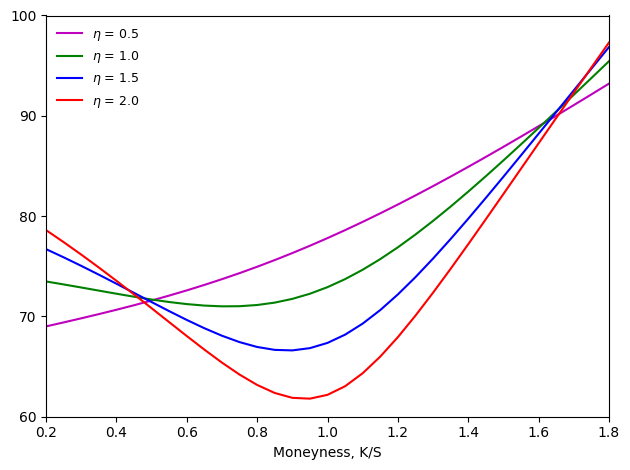

In [10]:
lambd = 0.25
b = 0.4
theta = 0.2

mness = np.arange(0.2, 1.85, 0.05)
strikes = mness * S
etas = np.array([0.5, 1.0, 1.5, 2.0])

prices = np.empty((len(etas), len(strikes)))
IV = np.empty((len(etas), len(strikes)))

for n in range(len(etas)):
    eta = etas[n]

    for i in range(len(strikes)):
        K = strikes[i]
        prices[n,i] = payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor)
        
        def bachelier_iv(x):
            return bachelier(S, K, x, date, expiry, tenor, delta = tau_floating_leg, t = 0) - prices[n,i]
        res = fsolve(bachelier_iv, 0.01)
        IV[n,i] = res * 10000   # convert to bp

fig, ax = plt.subplots()

ax.set_yticks(np.arange(rounddown(min(IV[0,:]))-10, roundup(max(IV[3,:]))+10, 10))
ax.set_ylim(rounddown(min(IV[0,:])), roundup(max(IV[3,:])))
ax.set_xlim(min(mness), max(mness))
ax.set_xlabel('Moneyness, K/S')
plt.plot(mness, IV[0,:], color = 'm', label = '$\\eta$ = '+str(etas[0]))
plt.plot(mness, IV[1,:], color = 'g', label = '$\\eta$ = '+str(etas[1]))
plt.plot(mness, IV[2,:], color = 'b', label = '$\\eta$ = '+str(etas[2]))
plt.plot(mness, IV[3,:], color = 'r', label = '$\\eta$ = '+str(etas[3]))
plt.legend(frameon=False, loc = 'upper left', fontsize=9)
fig.tight_layout()

### $\theta$ 5y10y

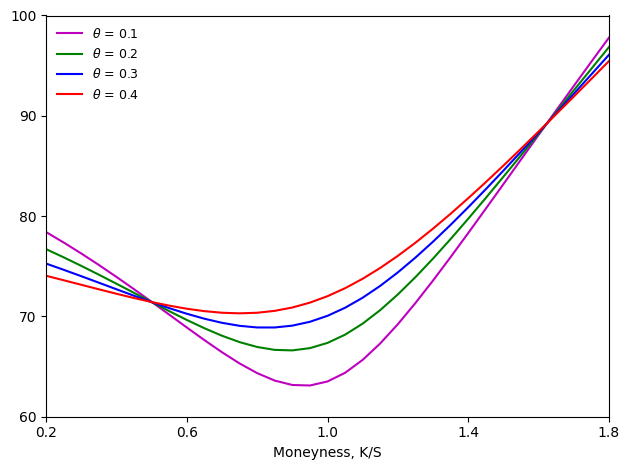

In [11]:
expiry = 5
tenor = 10

lambd = 0.25
b = 0.4
eta = 1.5

mness = np.linspace(0.2, 1.8, 33)
strikes = mness * S
thetas = np.array([0.1, 0.2, 0.3, 0.4])

prices = np.empty((len(thetas), len(strikes)))
IV = np.empty((len(thetas), len(strikes)))

for n in range(len(thetas)):
    theta = thetas[n]

    for i in range(len(strikes)):
        K = strikes[i]
        prices[n,i] = payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor)
        
        def bachelier_iv(x):
            return bachelier(S, K, x, date, expiry, tenor, delta = tau_floating_leg, t = 0) - prices[n,i]
        res = fsolve(bachelier_iv, 0.01)
        IV[n,i] = res * 10000   # convert to bp

fig, ax = plt.subplots()

ax.set_yticks(np.arange(rounddown(min(IV[0,:]))-10, roundup(max(IV[3,:]))+10, 10))
ax.set_ylim(rounddown(min(IV[0,:])), roundup(max(IV[3,:])))
ax.set_xlim(min(mness), max(mness))
ax.set_xticks(np.arange(0.2, 2.2, 0.4))
ax.set_xlabel('Moneyness, K/S')
plt.plot(mness, IV[0,:], color = 'm', label = '$\\theta$ = '+str(thetas[0]))
plt.plot(mness, IV[1,:], color = 'g', label = '$\\theta$ = '+str(thetas[1]))
plt.plot(mness, IV[2,:], color = 'b', label = '$\\theta$ = '+str(thetas[2]))
plt.plot(mness, IV[3,:], color = 'r', label = '$\\theta$ = '+str(thetas[3]))
plt.legend(frameon=False, loc = 'upper left', fontsize=9)
fig.tight_layout()

### $\theta$ 15y10y

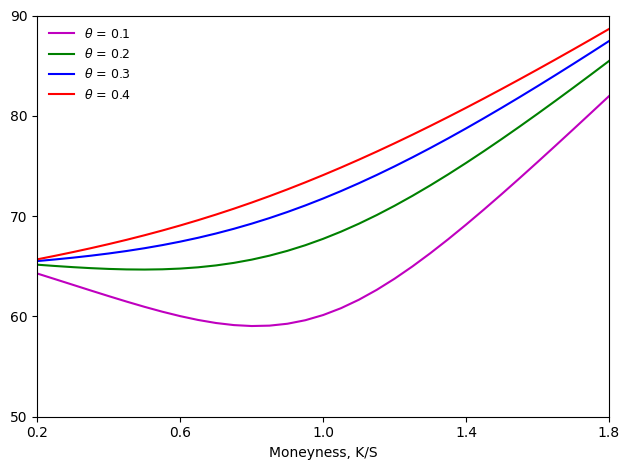

In [12]:
expiry = 15
tenor = 10

lambd = 0.25
b = 0.4
eta = 1.5

mness = np.linspace(0.2, 1.8, 33)
strikes = mness * S
thetas = np.array([0.1, 0.2, 0.3, 0.4])

prices = np.empty((len(thetas), len(strikes)))
IV = np.empty((len(thetas), len(strikes)))

for n in range(len(thetas)):
    theta = thetas[n]

    for i in range(len(strikes)):
        K = strikes[i]
        prices[n,i] = payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor)
        
        def bachelier_iv(x):
            return bachelier(S, K, x, date, expiry, tenor, delta = tau_floating_leg, t = 0) - prices[n,i]
        res = fsolve(bachelier_iv, 0.01)
        IV[n,i] = res * 10000   # convert to bp

fig, ax = plt.subplots()

ax.set_yticks(np.arange(rounddown(min(IV[0,:]))-10, roundup(max(IV[3,:]))+10, 10))
ax.set_ylim(rounddown(min(IV[0,:])), roundup(max(IV[3,:])))
ax.set_xlim(min(mness), max(mness))
ax.set_xticks(np.arange(0.2, 2.2, 0.4))
ax.set_xlabel('Moneyness, K/S')
plt.plot(mness, IV[0,:], color = 'm', label = '$\\theta$ = '+str(thetas[0]))
plt.plot(mness, IV[1,:], color = 'g', label = '$\\theta$ = '+str(thetas[1]))
plt.plot(mness, IV[2,:], color = 'b', label = '$\\theta$ = '+str(thetas[2]))
plt.plot(mness, IV[3,:], color = 'r', label = '$\\theta$ = '+str(thetas[3]))
plt.legend(frameon=False, loc = 'upper left', fontsize=9)
fig.tight_layout()